# Código para análise das áreas que serão comparadas no estudo

In [82]:
import rioxarray as rxr
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import mapping
from matplotlib.ticker import FuncFormatter
from utils import USO_SOLO_CLASS

In [25]:
sumidouro = gpd.read_file(r"D:\Mestrado\Trabalho Final\SIG\Sumidouro.zip")
area2     = gpd.read_file(r"D:\Mestrado\Trabalho Final\SIG\Area2.zip")

sumidouro.geometry

0    POLYGON ((594537.665 7783882.61, 594533.817 77...
Name: geometry, dtype: geometry

In [21]:
print("Projeção Sumidouro:", sumidouro.crs)
print("Projeção Área 2:", area2.crs)

Projeção Sumidouro: EPSG:31983
Projeção Área 2: EPSG:31983


In [22]:
def basin_geom_metrics(poly: gpd.GeoSeries | gpd.GeoDataFrame) -> dict:
    g = poly.geometry if isinstance(poly, gpd.GeoDataFrame) else poly
    area_m2 = g.area.item() if hasattr(g, "item") else g.area
    perim_m = g.length.item() if hasattr(g, "item") else g.length
    # compacidade de Gravelius
    k = perim_m / (2.0 * np.sqrt(np.pi * area_m2))
    return {
        "Área (km²)": area_m2 / 1e6,
        "Perímetro (km)": perim_m / 1000.0,
        "Compacidade": k,
    }

print("Sumidouro:")
print("\t\n".join([f"{k}: {v}" for k, v in basin_geom_metrics(sumidouro).items()]))

print("\nÁrea 2:")
print("\t\n".join([f"{k}: {v}" for k, v in basin_geom_metrics(area2).items()]))

Sumidouro:
Área (km²): 10.66805087038847	
Perímetro (km): 19.360864063714388	
Compacidade: 1.6721578219935491

Área 2:
Área (km²): 9.694919150296766	
Perímetro (km): 19.13852925586551	
Compacidade: 1.733929887427294


## Distribuição do Uso e Ocupação do Solo

In [23]:
uso_solo = rxr.open_rasterio(r"D:/Mestrado/Trabalho Final/SIG/USOSOLO.tif")

valor_nulo = uso_solo.rio.nodata
print("Nulos:", valor_nulo)

valores = uso_solo.values[0]
print("Valores:", valores.shape)

proj = uso_solo.rio.crs
print("Projeção:", proj)

Nulos: 15
Valores: (9099, 9099)
Projeção: EPSG:31983


In [ ]:
uso_sumidouro = uso_solo.rio.clip([mapping(sumidouro.geometry.union_all())], proj, drop=True)
uso_area2     = uso_solo.rio.clip([mapping(area2.geometry.union_all())], proj, drop=True)

print("Sumidouro:", uso_sumidouro.values.shape, uso_sumidouro.values.size)
print("Área 2:   ", uso_area2.values.shape, uso_area2.values.size)

Sumidouro: (1, 2629, 2226) 5852154
Área 2:    (1, 3094, 1981) 6129214


In [56]:
def counts_by_value(da, nodata=set()):
    arr = da.data
    arr = arr[np.isfinite(arr)].astype(int)
    if nodata:
        arr = arr[~np.isin(arr, list(nodata))]
    return pd.Series(arr).value_counts().sort_index(), arr.size

c_sumid, size_sumid = counts_by_value(uso_sumidouro, {0, 15})
c_area2, size_area2 = counts_by_value(uso_area2    , {0, 15})

print("Sumidouro:", c_sumid, "Total:", size_sumid)
print("Área 2:",    c_area2, "Total:", size_area2)

Sumidouro: 1        7616
2     1085384
3       53199
4      207289
5     1080527
6       35623
7      106355
8       50194
9       40815
13         88
Name: count, dtype: int64 Total: 2667090
Área 2: 1     39607
2    948014
3     33699
4    173413
5    982699
6     90914
7      8409
8     27306
9    119056
Name: count, dtype: int64 Total: 2423117


In [57]:
# --- junta e plota (x = valor do pixel) ---
df = pd.DataFrame({"Sumidouro": c_sumid, "Área 2": c_area2}).fillna(0).astype(int).reset_index()
df["Label"] = [USO_SOLO_CLASS[i]["name"] for i in df.index.values]
df = df[["Label", "Sumidouro", "Área 2"]]

df["Sumidouro %"] = (df["Sumidouro"]/size_sumid)*100
df["Área 2 %"]    = (df["Área 2"]/size_area2)*100

df

,Label,Sumidouro,Área 2,Sumidouro %,Área 2 %
0,No Data,7616,39607,0.285555,1.634548
1,Canga,1085384,948014,40.695440,39.123740
2,Vegetação Rasteira,53199,33699,1.994646,1.390729
3,Industrial,207289,173413,7.772104,7.156609
4,Residencial,1080527,982699,40.513331,40.555161
5,Vegetação Densa,35623,90914,1.335650,3.751944
6,Solo Exposto,106355,8409,3.987679,0.347032
7,Água,50194,27306,1.881976,1.126896
8,Pousio,40815,119056,1.530320,4.913341
9,Agricultura,88,0,0.003299,0.000000


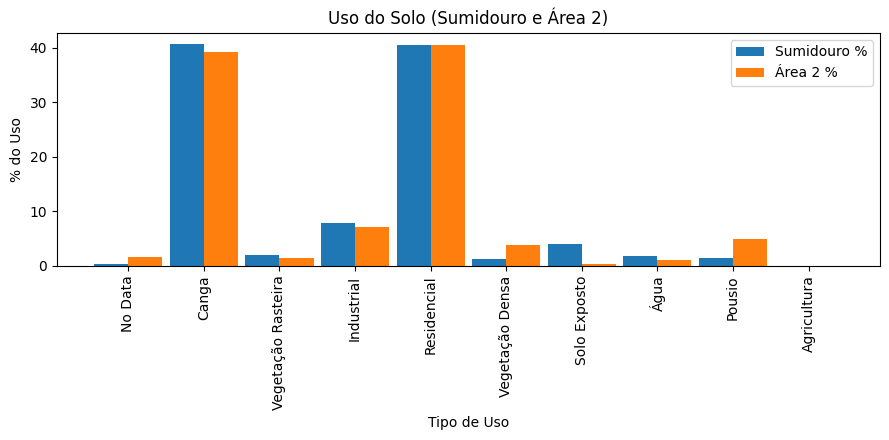

In [61]:
x = np.arange(len(df))
width = 0.45

plt.figure(figsize=(9, 4.5))
plt.bar(x - width/2, df['Sumidouro %'], width, label='Sumidouro %')
plt.bar(x + width/2, df["Área 2 %"], width, label="Área 2 %")
plt.xticks(x, df["Label"], rotation=90)
plt.ylabel("% do Uso")
plt.xlabel("Tipo de Uso")
plt.title("Uso do Solo (Sumidouro e Área 2)")
plt.legend()
plt.tight_layout()
plt.show()

## Distribuição da Elevação

In [62]:
elevacao = rxr.open_rasterio(r"d:\Mestrado\Trabalho Final\SIG\Elevation.tif")

valor_nulo = elevacao.rio.nodata
print("Nulos:", valor_nulo)

Nulos: None


In [63]:
el_sumidouro = elevacao.rio.clip([mapping(sumidouro.geometry.union_all())], proj, drop=True)
el_area2     = elevacao.rio.clip([mapping(area2.geometry.union_all())], proj, drop=True)

print("Sumidouro:", el_sumidouro.values.shape, el_sumidouro.values.size)
print("Área 2:   ", el_area2.values.shape, el_area2.values.size)

Sumidouro: (1, 2629, 2226) 5852154
Área 2:    (1, 3094, 1981) 6129214


In [65]:
def counts_by_value(da, nodata=set()):
    arr = da.data
    arr = arr[np.isfinite(arr)].astype(int)
    if nodata:
        arr = arr[~np.isin(arr, list(nodata))]
    return pd.Series(arr).value_counts().sort_index(), arr.size

c_el_sumid, size_el_sumid = counts_by_value(el_sumidouro, {None})
c_el_area2, size_el_area2 = counts_by_value(el_area2    , {None})

print("Sumidouro:", c_el_sumid, "Total:", size_el_sumid)
print("Área 2:",    c_el_area2, "Total:", size_el_area2)

Sumidouro: 791       1
792       5
793      21
794     292
795     304
       ... 
1093    176
1094    140
1095    114
1096     49
1097     22
Name: count, Length: 307, dtype: int64 Total: 2667090
Área 2: 824      15
825      53
826      85
827     251
828     313
       ... 
1346    196
1347    221
1348    214
1349    136
1350     59
Name: count, Length: 527, dtype: int64 Total: 2423690


In [70]:
# --- junta e plota (x = valor do pixel) ---
df = pd.DataFrame({"Sumidouro": c_el_sumid, "Área 2": c_el_area2}).fillna(0).astype(int).reset_index()
df = df.rename(columns={"index":"Elevation"})

df["Sumidouro %"] = (df["Sumidouro"]/size_el_sumid)*100
df["Área 2 %"]    = (df["Área 2"]/size_el_area2)*100

df

,Elevation,Sumidouro,Área 2,Sumidouro %,Área 2 %
0,791,1,0,0.000037,0.000000
1,792,5,0,0.000187,0.000000
2,793,21,0,0.000787,0.000000
3,794,292,0,0.010948,0.000000
4,795,304,0,0.011398,0.000000
...,...,...,...,...,...
555,1346,0,196,0.000000,0.008087
556,1347,0,221,0.000000,0.009118
557,1348,0,214,0.000000,0.008830
558,1349,0,136,0.000000,0.005611


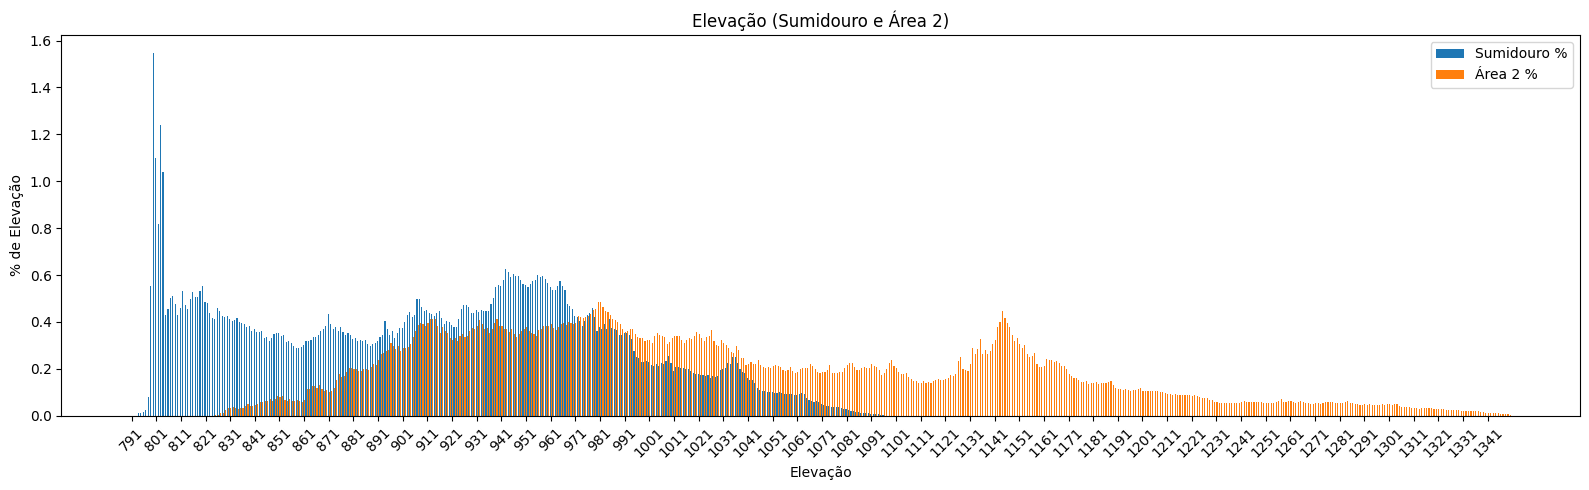

In [88]:
x = np.arange(len(df))
width = 0.45

plt.figure(figsize=(16, 5))
plt.bar(x - width/2, df['Sumidouro %'], width, label='Sumidouro %')
plt.bar(x + width/2, df["Área 2 %"], width, label="Área 2 %")

step = 10
plt.xticks(
    ticks=x[::step],
    labels=df["Elevation"].iloc[::step],# os valores correspondentes
    rotation=45
)

plt.ylabel("% de Elevação")
plt.xlabel("Elevação")
plt.title("Elevação (Sumidouro e Área 2)")
plt.legend()
plt.tight_layout()
plt.show()